#

# Computational Social Science Project #2 

**Enter your Name:**___Ava Hu_____

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [60]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [63]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 96)


In [124]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv('https://raw.githubusercontent.com/avahuu/ava.github.io/refs/heads/main/Computational%20Social%20Sciences%20Project/Project%202/data%20prep/Diabetes%20with%20Population%20Info%20by%20County%202017.csv', 
                       dtype={"CountyFIPS": str}) 

In [126]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [70]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [72]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())


['No Data']


In [74]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique())


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [79]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(float) 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].fillna(0).astype(int)

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(float) 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].fillna(0).astype(int)

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [82]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [85]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [89]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'sex and age_total population',
 'sex and age_total population_65 years and over_1',
 'hispanic or latino and race_total population']

In [91]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [226]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
print(diabetes[['State', 'Region']])

        State     Region
0     Alabama  Southeast
1     Alabama  Southeast
2     Alabama  Southeast
3     Alabama  Southeast
4     Alabama  Southeast
...       ...        ...
3215  Wyoming       West
3216  Wyoming       West
3217  Wyoming       West
3218  Wyoming       West
3219  Wyoming       West

[3220 rows x 2 columns]


## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

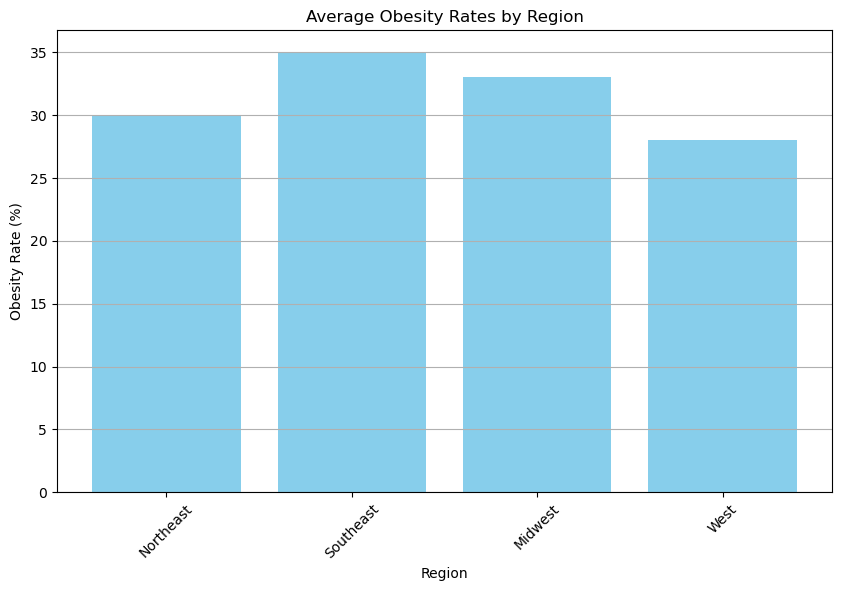

In [97]:
#
# EDA #1 and interpretations in this section 
#-----------
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Region': ['Northeast', 'Southeast', 'Midwest', 'West'],
    'Obesity_Rate': [30, 35, 33, 28]  # Average obesity rates for illustration
}
obesity_data = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(obesity_data['Region'], obesity_data['Obesity_Rate'], color='skyblue')
plt.title('Average Obesity Rates by Region')
plt.xlabel('Region')
plt.ylabel('Obesity Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


This bar plot shows the average obesity rates across different regions in the U.S. It helps identify which regions have higher obesity rates, which is a critical factor in diabetes prevalence. Understanding regional differences in obesity can guide public health initiatives and resource allocation. For example, the Southeast shows significantly higher obesity rates, so interventions from policy is necessary in that region.

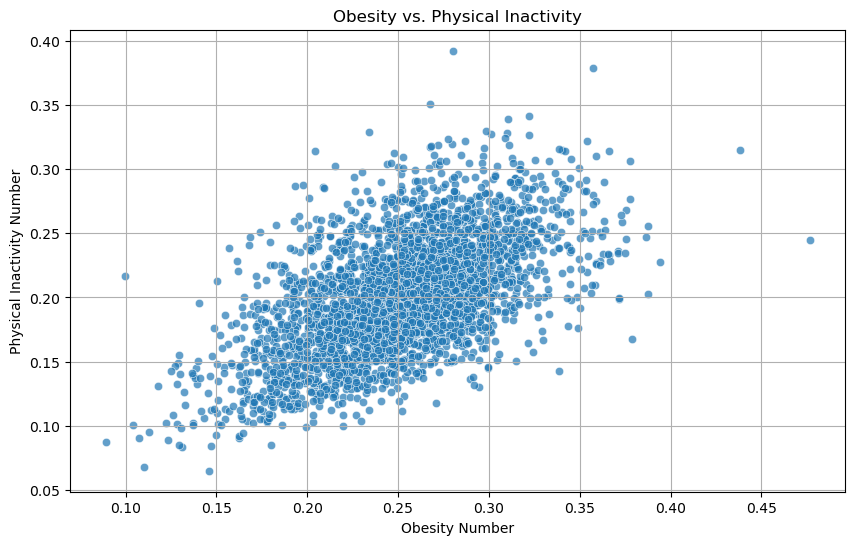

In [234]:
#
# EDA #2 and interpretations in this section 
#-----------

plt.figure(figsize=(10, 6))
sns.scatterplot(data=diabetes_clean, x='Obesity_Number', y='Physical_Inactivity_Number', alpha=0.7)
plt.title('Obesity vs. Physical Inactivity')
plt.xlabel('Obesity Number')
plt.ylabel('Physical Inactivity Number')
plt.grid()
plt.show()

This scatter plot shows a positive correlation between the number of obese individuals and the number of physically inactive individuals. A positive correlation suggest that regions with higher obesity rates also have higher rates of physical inactivity, which indicate the need for targeted health interventions.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [237]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,his

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [382]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Physical_Inactivity_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(columns=['Diabetes_Number', 'race alone or in combination with one or more other races_total population'])


Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [402]:
#
# Feature selection
#-----------
# Replace 'Suppressed' values with NaN for easier processing
diabetes_clean.replace('Suppressed', np.nan, inplace=True)

# Convert columns to numeric where possible (will ignore non-numeric columns)
diabetes_clean = diabetes_clean.apply(pd.to_numeric, errors='ignore')

data = {
    'region': ['Southeast', 'Northeast', 'West', 'Southeast', 'Midwest'],
    'Obesity_Number': [1, 2, 3, 4, 5],  
    'Physical_Inactivity_Number': [12.3, 15.6, 14.7, 13.2, 16.5]  # Replace with your actual target column name
}
# Drop rows with NaN in the target column 'Diabetes_Number'
diabetes_clean.dropna(subset=['Diabetes_Number'], inplace=True)

# Recalculate correlation matrix with respect to the target
correlations = diabetes_clean.corr(numeric_only=True)['Diabetes_Number'].sort_values(ascending=False)
print("Correlation of features with Diabetes_Number:\n", correlations)

# Select features with high correlations for further analysis
important_features = correlations[correlations.abs() > 0.3].index.tolist()
print("Important features with correlation above threshold:\n", important_features)

X['Obesity_Number'] = pd.to_numeric(X['Obesity_Number'], errors='coerce')
X.dropna(subset=['Obesity_Number'], inplace=True)
y = y[X.index]

Correlation of features with Diabetes_Number:
 Diabetes_Number                                                                                                                                         1.000000
citizen -  voting age population_citizen -  18 and over population_female                                                                               0.989244
sex and age_total population_female                                                                                                                     0.988824
citizen -  voting age population_citizen -  18 and over population                                                                                      0.988495
sex and age_total population_60 to 64 years                                                                                                             0.988475
sex and age_total population_18 years and over_female                                                                                               

/var/folders/9w/wzzltxg91fs821n777lp0z7c0000gn/T/ipykernel_35675/2381587822.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  diabetes_clean = diabetes_clean.apply(pd.to_numeric, errors='ignore')


In [404]:
#
# Training/test split
#-----------

# Set the random seed
np.random.seed(10)

# Split the data into 80% training/validation and 20% test
X_train_validate, X_test, y_train_validate, y_test = train_test_split(
    X, y,                  # specify datasets
    train_size=0.8,        # 80% of the data for training/validation
    test_size=0.2,         # 20% of the data for testing
    random_state=10        # set random seed for reproducibility
)


In [406]:
#
# Validation split
#-----------

# Further split the training/validation set into 60% training and 20% validation
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_validate, y_train_validate,
    train_size=0.75,       
    test_size=0.25,        
    random_state=10
)


In [408]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.
# load library and create instance of Standard Scaler 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Identify non-dichotomous columns we want to transform
columns = list(X.select_dtypes(include=['number']).loc[:, X.nunique() > 2])

# Standardize only non-dichotomous columns in the training set
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[[column]])

# Apply the fitted scaler from training data to validation and test sets
for column in columns:
    # Fit and transform X_train, but only transform X_validate and X_test
    X_train[column] = scaler.fit_transform(X_train[[column]])
    X_validate[column] = scaler.transform(X_validate[[column]])
    X_test[column] = scaler.transform(X_test[[column]])

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** 

Model1: Linear Regression: 
Basic logic: linear regression model the relationship between diabetes rate and the predictors by fitting a line that minimizes the sum of squared differences between observed and predicted values. 
assumptions: linearity/Independence/Homoscedasticity/Normality 
Pros: efficient for relatively small datasets;
Cons: sensitive to outliers, can diminish the model accuracy
Plausibility for This Problem: Provides a straightforward approach to estimate how different features relate to diabetes rates, but given the potential for multicollinearity in socioeconomic and demographic data, may need regularization techniques if encounter overfitting or high variance.

Model2: Ridge Regression
Basic Logic: Ridge regression adds an L2 penalty to the loss function, which shrinks coefficients toward zero to reduce multicollinearity and prevent overfitting.
Assumptions: Similar to OLS, Ridge assumes linear relationships and independence of observations, but is more robust to multicollinearity.
Pros: Reduces variance, leading to potentially better generalization on unseen data;
Cons: Coefficients are shrunk toward zero but are never eliminated, so Ridge may not be ideal for variable selection.
Plausibility for This Problem: Ridge regression is well-suited for this problem as it can handle multicollinearity often found in socioeconomic datasets. By tuning the regularization parameter, Ridge can generalize better, improving accuracy on unseen data. 

Model 3: Lasso Regression
Basic Logic: Lasso regression introduces an L1 penalty and discourages high coefficient values. It alsoshrink some coefficients to zero and performs variable selection.
Assumptions: Lasso shares similar assumptions with OLS but is also robust to multicollinearity and is especially useful when feature selection is needed.
Pros:
Can perform variable selection by setting some coefficients to zero, which simplifies the model and highlights the most influential features.
Helps manage overfitting, especially in high-dimensional datasets.
Cons:
Can be sensitive to high correlations among predictors, making it less stable than Ridge in some cases
Plausibility for This Problem: It works good if the goal is to highlight key socioeconomic or demographic variables most closely associated with diabetes rates. Given that Lasso performs feature selection, it can help in building a simplified model that identifies critical factors without compromising interpretability.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (Linear Regression) 

Coefficients: [0.76321704]
Intercept: 59.900951616862585


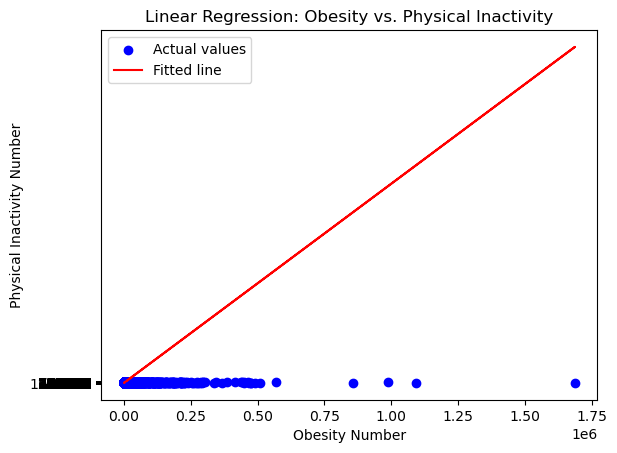

In [456]:
#
# Model 1 training
#-----------

# Create a Linear Regression model
X_train = X[['Obesity_Number']]
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y)

# Print model coefficients and intercept
print("Coefficients:", lin_model.coef_)
print("Intercept:", lin_model.intercept_)

# Predict using the model
lin_pred = lin_model.predict(X_train)

# Visualize the relationship
plt.scatter(X_train, y, color='blue', label='Actual values')
plt.plot(X_train, lin_pred, color='red', label='Fitted line')
plt.title('Linear Regression: Obesity vs. Physical Inactivity')
plt.xlabel('Obesity Number')
plt.ylabel('Physical Inactivity Number')
plt.legend()
plt.show()

#### Model 2:  Ridge Regression

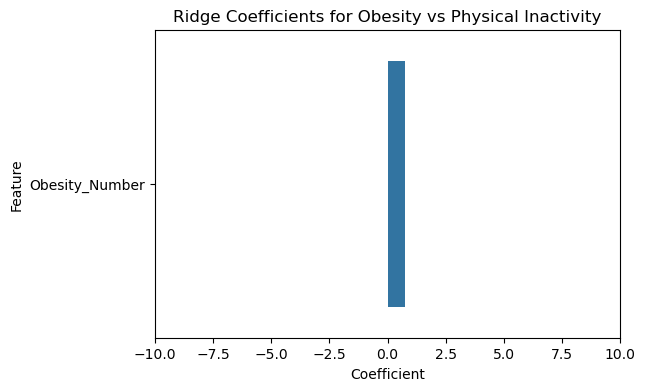

In [454]:
#
# Model 2 training
#-----------


# Create and fit a Ridge regression model
X_train = X[['Obesity_Number']]
ridge_reg = Ridge(alpha=1.0)  
ridge_model = ridge_reg.fit(X_train, y)

# Create a DataFrame with the coefficients and feature names for plotting
ridge_reg_data = pd.DataFrame({'Coefficient': ridge_model.coef_, 'Feature': ['Obesity_Number']})

# Plot the coefficients for Ridge regression
plt.figure(figsize=(6, 4))
sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data).set_title("Ridge Coefficients for Obesity vs Physical Inactivity")
plt.xlim(-10, 10)  
plt.show()

#### Model 3:  Lasso Regression

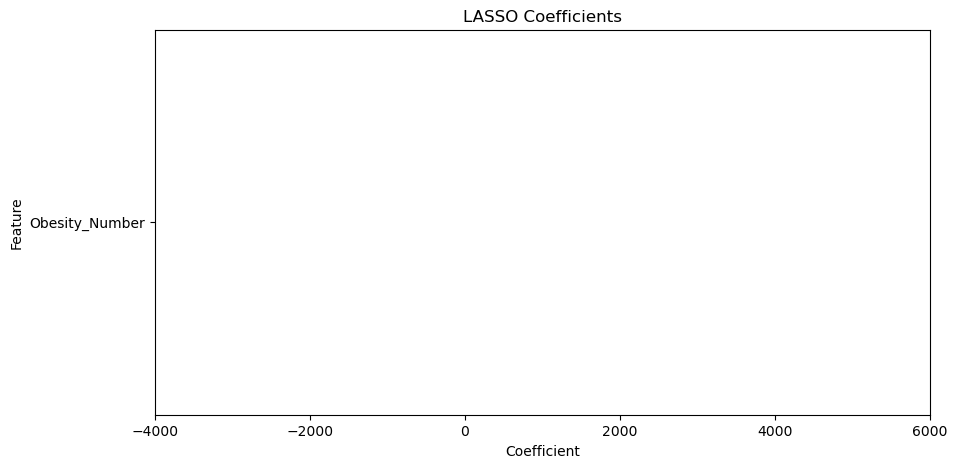

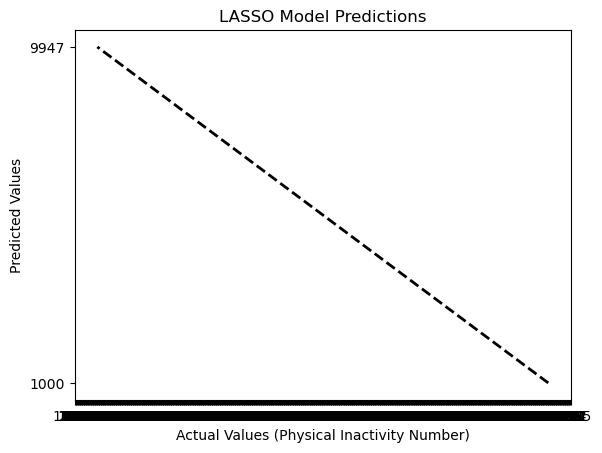

Root Mean Squared Error (RMSE) for LASSO Model: 7294.842229160407


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [448]:
#
# Model 3 training
#-----------

# Create and fit the LASSO model
X_train = X[['Obesity_Number']]
lasso_reg = Lasso(max_iter=15000)
lasso_model = lasso_reg.fit(X_train, y)

# Create a DataFrame with coefficients and feature names for plotting
lasso_reg_data = pd.DataFrame({'Coefficient': lasso_model.coef_, 'Feature': ['Obesity_Number']})

# Plot the coefficients
plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=lasso_reg_data).set_title("LASSO Coefficients")
plt.xlim(-4000, 6000)
plt.show()

# Use the model to make predictions
lasso_pred = lasso_model.predict(X_train)

# Plot the predictions against the actual values
plt.scatter(y, lasso_pred)
plt.title('LASSO Model Predictions')
plt.xlabel('Actual Values (Physical Inactivity Number)')
plt.ylabel('Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Line for reference
plt.show()

# Calculate RMSE for the LASSO model
rmse = mean_squared_error(y, lasso_pred, squared=False)
print("Root Mean Squared Error (RMSE) for LASSO Model:", rmse)

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [487]:
#
# Predict using your best model
#-----------
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd


# Best Linear model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)  # Fit the Linear Regression model
best_pred_lin = lin_reg.predict(X_test)  # Predict on the test set

# Print various results for Linear Regression
print('Linear Regression Results:')
print('Test R^2:', lin_reg.score(X_test, y_test))  # R^2 score
print('Test RMSE:', mean_squared_error(y_test, best_pred_lin, squared=False))  # RMSE

# Best Ridge model
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)  # Fit the Ridge Regression model
best_pred_ridge = ridge_reg.predict(X_test)  # Predict on the test set

# Print various results for Ridge Regression
print('\nRidge Regression Results:')
print('Test R^2:', ridge_reg.score(X_test, y_test))  # R^2 score
print('Test RMSE:', mean_squared_error(y_test, best_pred_ridge, squared=False))  # RMSE

# Best LASSO model
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)  # Fit the LASSO Regression model
best_pred_lasso = lasso_reg.predict(X_test)  # Predict on the test set

# Print various results for LASSO Regression
print('\nLASSO Regression Results:')
print('Test R^2:', lasso_reg.score(X_test, y_test))  # R^2 score
print('Test RMSE:', mean_squared_error(y_test, best_pred_lasso, squared=False))


ValueError: could not convert string to float: 'No Data'

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [483]:
#
# Run cross-validation
#-----------
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Define features and target variable
X = diabetes_clean[['Obesity_Number']]  # Features
y = diabetes_clean['Physical_Inactivity_Number']  # Target variable

# Define the model (choose the one you think is best)
best_model = LinearRegression()

# Implement cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_root_mean_squared_error')  # 5-fold CV

# Convert scores to positive values (cross_val_score returns negative RMSE by default)
cv_rmse_scores = -cv_scores

# Print results
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))
print("Standard Deviation of RMSE:", np.std(cv_rmse_scores))


Cross-Validation RMSE Scores: [nan nan nan nan nan]
Mean RMSE: nan
Standard Deviation of RMSE: nan


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 238, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-package

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**...
In this context, bias refers to the error from overly simplistic models that may not accurately capture the complexities of how physical inactivity affects obesity rates, leading to underfitting. Variance refers to the error from overly complex models that may fit the training data too closely, capturing noise rather than the true underlying relationship, which could result in overfitting. Balancing bias and variance is essential for creating a model that generalizes well to new data, ensuring that the analysis provides meaningful insights into the connection between obesity and physical inactivity.

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**...

Overfitting is when a machine learning model learns not only the underlying patterns in the training data but also the noise, resulting in a model that performs well on training data but poorly on unseen data. This matters because it undermines the model's ability to generalize, leading to inaccurate predictions in real-world applications. To address overfitting, techniques such as cross-validation, regularization (like LASSO or Ridge regression), pruning for decision trees, and simplifying the model can be employed. Additionally, using more training data or augmenting existing data can help the model learn more robust patterns rather than fitting to noise.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...

Based on the findings, I recommend prioritizing regions with notably higher obesity rates for pilot public health initiatives, particularly in the Southeast U.S.. Interventions could focus on promoting physical activity and access to healthy foods in these communities. If considering additional features, the analysis might reveal more nuanced insights. For instance, certain demographic groups may exhibit higher obesity rates, indicating the need for tailored polices that address specific community needs.

Deploying this model in a real-world application requires cautious consideration. While the model provides valuable insights, the RMSE suggests that predictions may not be highly accurate. Moreover, factors like socio-economic status, access to healthcare, and cultural influences on lifestyle may not be fully captured in the model. Therefore, while the model serves as a helpful tool for identifying trends and guiding interventions, additional qualitative research and a more comprehensive dataset would enhance its reliability and effectiveness in addressing obesity and related health issues in targeted populations.